In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
churnData=pd.read_csv('Customer-Churn.txt')
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [3]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

## Nulls & Duplicates

Como se puede ver con el .info(), por ahora no hay nulos en el DataFrame

In [4]:
churnData.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
churnData.TotalCharges.unique()


array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

Queremos pasar la variable 'TotalCharges' a numérica. Sus valores únicos son números en general, sin embargo está como object.
Puede que hayan vacíos, una combinación de números y strings, entre otras cosas. Lo que vamos a hacer es usar un errors coerce
para que transforme los valores no numéricos a NaNs y luego los imputaremos.

In [6]:
churnData.TotalCharges=pd.to_numeric(churnData.TotalCharges, errors='coerce')

In [7]:
churnData.TotalCharges.dtypes
#La variable quedó como float.

dtype('float64')

In [8]:
churnData.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Luego de pasarla a numérica, quedaron 11 nulos en 'TotalCharges'. Veremos cómo es la distribución para decidir con qué
método imputarlos

In [9]:
#Porcentaje de nulos
percent=11/7043*100
print(f'Hay {percent:.2f}% de nulos en TotalCharges')

Hay 0.16% de nulos en TotalCharges


In [10]:
#Importamos librerías para hacer gráficas
import seaborn as sns
import matplotlib.pyplot as plt

Histograma de TotalCharges (mediana en rojo, media en verde)

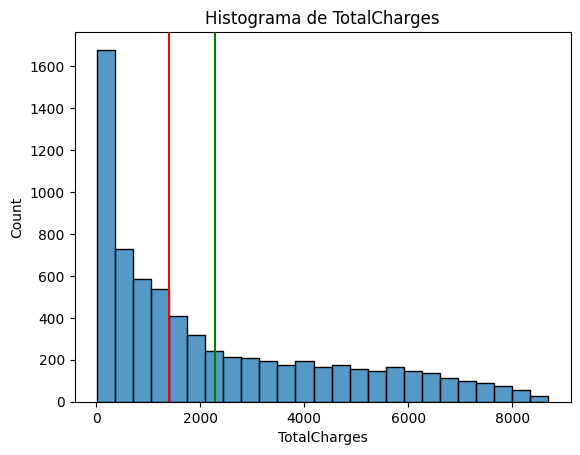

In [11]:
sns.histplot(churnData.TotalCharges)
plt.axvline(churnData.TotalCharges.median(), c="r", label="median")
plt.axvline(churnData.TotalCharges.mean(), c="g", label="mean");
plt.title('Histograma de TotalCharges')
plt.show()
#Quitar los nulos para el gráfico no es necesario porque como vimos anteriormente, son muy pocos.

Dado que la distribución está bastante skewed, no estaría bien imputar con la media. Se elige imputar con 
la mediana

In [12]:
churnData.TotalCharges=churnData.TotalCharges.fillna(churnData.TotalCharges.median())

Verificación de que ya no quedan nulos nulos

In [13]:
sum(churnData.isna().sum())

0

Veamos si hay filas duplicadas

In [14]:
churnData.duplicated().sum()

49

Hay 49, las vamos eliminar

In [15]:
churnData.drop_duplicates(inplace=True)

## Analysis

In [16]:
features=['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']

Veamos qué tipo de variables son las features y la variable 'Churn', ya que esta última va a ser nuestra variable target

In [17]:
df=pd.DataFrame(churnData[features+['Churn']])
df.dtypes

tenure              int64
SeniorCitizen       int64
MonthlyCharges    float64
TotalCharges      float64
Churn              object
dtype: object

Se puede ver que 'Churn' está como object, por lo que habría que pasarla a numérica para que funcione
el modelo que se va a realizar

In [18]:
churnData.Churn.value_counts()

Churn
No     5144
Yes    1850
Name: count, dtype: int64

In [19]:
churnData.Churn=churnData.Churn.replace({'Yes': 1, 'No':0})

Definimos la variable target y el vector de variables independientes

In [20]:
y=churnData['Churn']
X=churnData[features] 
#Recordemos que las features son numéricas por lo que:
X_num=X

Veamos qué tan relacionadas están las variables mediante un Heatmap

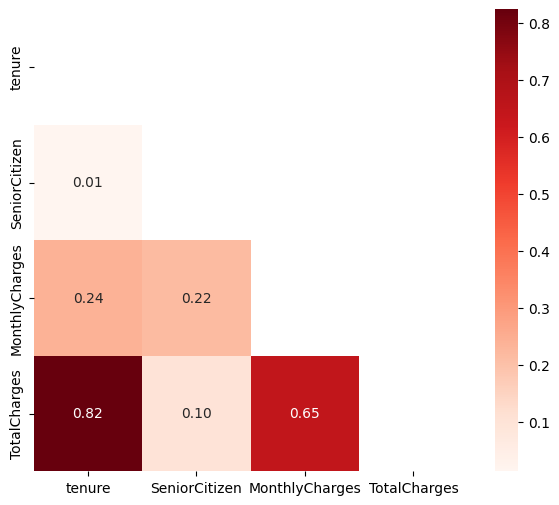

In [21]:
correlation_matrix=X.corr()

plt.figure(figsize=(7,6))
mask=np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='Reds', fmt='.2f')
plt.show()

Matriz de Correlación

In [22]:
correlation_matrix

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
tenure,1.000000,0.013215,0.239931,0.824131
SeniorCitizen,0.013215,1.000000,0.217970,0.100416
MonthlyCharges,0.239931,0.217970,1.000000,0.648693
TotalCharges,0.824131,0.100416,0.648693,1.000000


Veamos un VIF (ya que el heatmap solo ve la colinearidad entre pares de variables, mientras que el VIF ve las multicolinearidades de manera más global, por lo que
nos puede aportar información)

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

#No hay valores superiores a 10 --> OK

,Variable,VIF
0,tenure,6.322155
1,SeniorCitizen,1.257670
2,MonthlyCharges,3.713080
3,TotalCharges,8.089727


### Transformations

Escalar

In [24]:
from sklearn.preprocessing import MinMaxScaler 

transformer=MinMaxScaler().fit(X_num)
transformer
x_scaled=transformer.transform(X_num)
print(x_scaled.shape)
pd.DataFrame(x_scaled)

(6994, 4)


,0,1,2,3
0,0.013889,0.0,0.115423,0.001275
1,0.472222,0.0,0.385075,0.215867
2,0.027778,0.0,0.354229,0.010310
3,0.625000,0.0,0.239303,0.210241
4,0.027778,0.0,0.521891,0.015330
...,...,...,...,...
6989,0.333333,0.0,0.662189,0.227521
6990,1.000000,0.0,0.845274,0.847461
6991,0.152778,0.0,0.112935,0.037809
6992,0.055556,1.0,0.558706,0.033210


Normalizar

In [25]:
from sklearn.preprocessing import Normalizer
transformer=Normalizer().fit(X)
x_normalized=transformer.transform(X)
print(x_normalized)

[[0.02368203 0.         0.70690847 0.70690847]
 [0.0179831  0.         0.0301217  0.99938446]
 [0.01655198 0.         0.44566203 0.89504826]
 ...
 [0.03161954 0.         0.08508531 0.99587183]
 [0.01267729 0.00316932 0.23579761 0.97171433]
 [0.00964118 0.         0.0154332  0.99983442]]


### Logistic Regression Model

Escalando

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, stratify=y, random_state=42)
model=LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [27]:
model.score(X_test, y_test)

0.7905646890636169

Normalizando

In [28]:
X_train, X_test, y_train, y_test= train_test_split(x_normalized,y, test_size=0.2, random_state=42)

In [29]:
model=LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [30]:
model.score(X_test,y_test)

0.7812723373838456

Los 2 modelos dan muy similar. Me quedo con el de **escalar** por ser el que da mejor (da más cerca de 1)

### Confusion Matrix

Formato de la matriz

|                    | Predicción Positiva | Predicción Negativa |
|--------------------|---------------------|---------------------|
| **Clase Real Positiva** | Verdaderos Positivos (VP) | Falsos Negativos (FN) |
| **Clase Real Negativa** | Falsos Positivos (FP)   | Verdaderos Negativos (VN) |

In [31]:
from sklearn.metrics import confusion_matrix
y_predicted=model.predict(X_test)
confusion_matrix(y_test, y_predicted)

array([[997,  60],
       [246,  96]], dtype=int64)

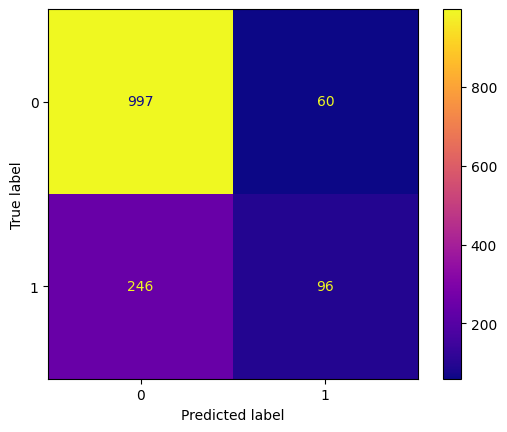

In [32]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test, y_predicted)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='plasma') 
plt.show()

Los resultados indican que el modelo predijo correctamente que 997 clientes hicieron Churn. Ese valor es por bastante margen el más grande de los 4 lo
cual habla bien del modelo. Además, el caso más grave dentro de los errores del modelo sería el que dio 96 ya que el modelo dio que en 96 casos no hubo Churn, cuando en realidad sí hubo. Por suerte, este último valor fue el más bajo de los 4.

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1057
           1       0.62      0.28      0.39       342

    accuracy                           0.78      1399
   macro avg       0.71      0.61      0.63      1399
weighted avg       0.76      0.78      0.75      1399



Un accuracy de .78 indica que el modelo acertó en el 78% de los casos // (997+96)/Total

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


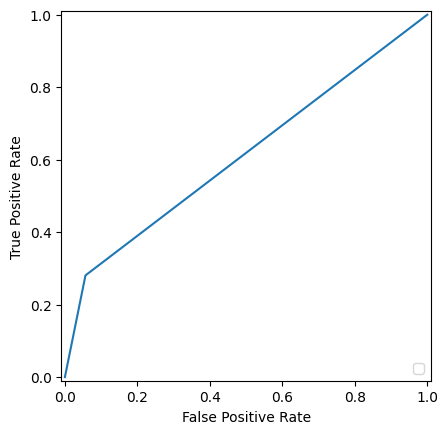

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted) 
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot()
plt.show()

Tiene cierta forma de codo aunque no es ideal

### Imbalance Managment

In [36]:
data=pd.concat([X,y], axis=1)

In [37]:
data

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges,Churn
0,1,0,29.85,29.85,0
1,34,0,56.95,1889.50,0
2,2,0,53.85,108.15,1
3,45,0,42.30,1840.75,0
4,2,0,70.70,151.65,1
...,...,...,...,...,...
7038,24,0,84.80,1990.50,0
7039,72,0,103.20,7362.90,0
7040,11,0,29.60,346.45,0
7041,4,1,74.40,306.60,1


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6994 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          6994 non-null   int64  
 1   SeniorCitizen   6994 non-null   int64  
 2   MonthlyCharges  6994 non-null   float64
 3   TotalCharges    6994 non-null   float64
 4   Churn           6994 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 327.8 KB


In [39]:
data.isna().sum()

tenure            0
SeniorCitizen     0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64

In [40]:
data.Churn.value_counts()

Churn
0    5144
1    1850
Name: count, dtype: int64

A continuación veremos 2 métodos para tratar el imbalance: Downsampling y Upsampling

### 1) Downsampling

In [41]:
category_0=data[data['Churn']==0]
category_1=data[data['Churn']==1]

In [42]:
category_0 = category_0.sample(len(category_1), replace=True)
print(category_1.shape)
print(category_0.shape)

(1850, 5)
(1850, 5)


In [43]:
data=pd.concat([category_0, category_1], axis=0)
data=data.sample(frac=1)
data['Churn'].value_counts()

Churn
1    1850
0    1850
Name: count, dtype: int64

In [44]:
downsampling=pd.concat([category_0, category_1], axis=0)

downsampling=downsampling.sample(frac=1)
downsampling.Churn.value_counts()

Churn
0    1850
1    1850
Name: count, dtype: int64

In [45]:
X=downsampling
y=downsampling['Churn']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
model=LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [47]:
model.score(X_test, y_test)

1.0

Esto significa que el accuracy de la predicción del modelo es del 100%

### 2) Upsampling

In [48]:
X=churnData[features]
y=churnData.Churn

In [49]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 6994, dtype: int64

In [50]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 6994, dtype: int64

In [51]:
data2=pd.concat([X,y], axis=1)

In [52]:
data2.Churn.value_counts()

Churn
0    5144
1    1850
Name: count, dtype: int64

In [53]:
category_0=data2[data2['Churn']==0]
category_1=data2[data2['Churn']==1]

In [54]:
print(len(category_0))
print(len(category_1))

5144
1850


In [55]:
category_1=category_1.sample(len(category_0), replace=True)
print(category_1.shape)
print(category_0.shape)

(5144, 5)
(5144, 5)


In [56]:
up=pd.concat([category_1, category_0], axis=0)

up=up.sample(frac=1)
up.Churn.value_counts()

Churn
0    5144
1    5144
Name: count, dtype: int64

In [57]:
X=up
y=up['Churn']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
model=LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [59]:
model.score(X_test, y_test)

1.0

Al igual que en downsampling, el accuracy de la predicción del modelo es del 100%